In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_tables    = '/Users/Guille/Desktop/india_power/tables'

In [2]:
# Grab data from databases for plotting LCOE emissions
def _load_cost(scen_labels_):
    # Load fuel, and operation and maintanace cost table and process data from database
    def __load_vr_cost_from_csv(df_, scenario):
        
        df_['variable_om_cost'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['variable_om_cost']
         
        df_ = df_[['period', 'technology', 'load_zone', 'variable_om_cost']]
        df_ = df_.rename(columns = {'variable_om_cost': 'variable_cost'})
        df_ = df_.groupby(['period', 
                           'technology',
                           'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_

    # Load fix capacity cost table and process data from database
    def __load_fx_cost_from_csv(project_, new_, spec_, scenario):
        
        new_ = new_.fillna({'capacity_cost': 0, 'fixed_cost': 0})
        
        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']

        new_ = new_[['period', 'technology', 'load_zone', 'fixed_cost']]
        new_ = new_.groupby(['period', 
                             'technology', 
                             'load_zone']).sum().reset_index(drop = False)
                             
        spec_['fixed_cost'] = spec_['fixed_cost_per_mw_yr'] 

        spec_ = pd.merge(spec_, project_, on = ['project'])
        spec_ = spec_[['period', 'technology', 'load_zone', 'fixed_cost']]
        spec_ = spec_.groupby(['period', 
                               'technology', 
                               'load_zone']).sum().reset_index(drop = False)

        df_ = pd.concat([new_, spec_], axis = 0)
        df_ = df_.groupby(['period', 
                           'technology',
                           'load_zone']).sum().reset_index(drop = False)
        
        df_['scenario'] = scenario    

        return df_

    # Load transmission capacity cost table and process data from database
    def __load_tx_cost_from_csv(project_, new_, scenario):

        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']
        
        new_ = new_[['period', 'transmission_line', 'max_mw', 'fixed_cost']]
        new_ = new_.rename(columns = {'max_mw': 'power_mw'})
        df_  = new_.groupby(['period', 
                             'transmission_line']).sum().reset_index(drop = False)
        project_ = project_.loc[project_['vintage'] == 2020].reset_index(drop = False)
        project_ = project_[['transmission_line', 'tx_annualized_real_cost_per_mw_yr']]
        
#         project_p_                      = project_.copy()
#         project_p_['transmission_line'] = project_p_['transmission_line'].str.replace('_new', '')
#         project_ = pd.concat([project_, project_p_], axis = 0).reset_index(drop = True)

        df_                  = pd.merge(df_, project_, on = ['transmission_line'])
        df_['capacity_cost'] = df_['tx_annualized_real_cost_per_mw_yr']*df_['power_mw']
        df_['load_zone']     = df_['transmission_line'].apply(lambda x: x.split("-")[0])
        df_                  = df_[['period', 'load_zone', 'capacity_cost', 'fixed_cost']]
        df_                  = df_.groupby(['period', 
                                            'load_zone']).agg({'capacity_cost': 'sum', 
                                                               'fixed_cost': 'sum'}).reset_index(drop = False)
        df_['fixed_cost']    = df_['capacity_cost'] + df_['fixed_cost']
        df_['variable_cost'] = 0.
        df_                  = df_[['period', 'load_zone', 'fixed_cost', 'variable_cost']]
        df_['technology']    = 'Transmission Losses'    
        df_['scenario']      = scenario    
        
        return df_

    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['static_load_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_ = df_[['period', 'load_zone', 'static_load_mw']]
        df_ = df_.groupby(['period', 
                           'load_zone']).sum().reset_index(drop = False)
                         
        df_['technology'] = 'Demand'     
        df_['scenario']   = scenario     

        return df_.rename(columns = {'static_load_mw': 'load_mw'})

    dfs_1_ = []
    dfs_2_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)        

        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)
        
        # Load fix costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/project_period.csv', low_memory = False)
        spec_    = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_ = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        fx_      = __load_fx_cost_from_csv(project_, new_, spec_, scen)
        
        # Load variables costs from csv files
        vr_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        vr_ = __load_vr_cost_from_csv(vr_, scen)
        
        # Load tx costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/transmission_period.csv', low_memory = False) 
        spec_    = pd.read_csv(dir_name + r'/inputs/specified_transmission_line_capacities.tab', sep = '\t', engine = 'python')        
        project_ = pd.read_csv(dir_name + r'/inputs/new_build_transmission_vintage_costs.tab', sep = '\t', engine = 'python')
        tx_      = __load_tx_cost_from_csv(project_, new_, scen)

        df_ = pd.merge(vr_, fx_, on = ['scenario', 'technology', 'period', 'load_zone'])
        df_ = pd.concat([df_, tx_], axis = 0)

        dfs_1_.append(df_)
        dfs_2_.append(load_)

    df_1_ = pd.concat(dfs_1_, axis = 0).reset_index(drop = True)
    df_2_ = pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

    df_1_['period']        = df_1_['period'].astype(int)
    df_1_['fixed_cost']    = df_1_['fixed_cost'].astype(float)
    df_1_['variable_cost'] = df_1_['variable_cost'].astype(float)
    
    df_2_['period']  = df_2_['period'].astype(int)
    df_2_['load_mw'] = df_2_['load_mw'].astype(float)

    return df_1_, df_2_

In [3]:
def _group_cost_by_tech(df_1_, df_2_, scen_labels_):

    columns_ = ['period', 'technology', 'scenario', 'load_zone']
    
    dfs_1_ = []
    dfs_2_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_1_p_ = df_1_.loc[df_1_['scenario'] == scen].copy()
        df_2_p_ = df_2_.loc[df_2_['scenario'] == scen].copy()

        idx_1_ = df_1_p_['load_zone'] == zone
        idx_2_ = df_2_p_['load_zone'] == zone

        if idx_1_.sum() == 0.:
            df_1_p_['load_zone'] = 'all'
            df_2_p_['load_zone'] = 'all'
        else:
            df_1_p_ = df_1_p_.loc[idx_].reset_index(drop = True)
            df_2_p_ = df_2_p_.loc[idx_].reset_index(drop = True)

        dfs_1_.append(df_1_p_.groupby(columns_).sum().reset_index(drop = False))
        dfs_2_.append(df_2_p_.groupby(columns_).sum().reset_index(drop = False))

    df_1_ = pd.concat(dfs_1_, axis = 0).reset_index(drop = True)
    df_2_ = pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

    df_1_['period']        = df_1_['period'].astype(int)
    df_1_['fixed_cost']    = df_1_['fixed_cost'].astype(float)
    df_1_['variable_cost'] = df_1_['variable_cost'].astype(float)

    df_2_['period']  = df_2_['period'].astype(int)
    df_2_['load_mw'] = df_2_['load_mw'].astype(float)
    
    return df_1_, df_2_

def _group_tech(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'variable_cost': 'sum', 
                                         'fixed_cost': 'sum'})

    return df_.reset_index(drop = False)

In [4]:
def _plot_total_fixed_and_variable_cost(axp, df_, scens_label_, tech_label_, 
                                        USD_to_INR   = 72,
                                        y_lim_max    = 400,
                                        units        = 1e9,
                                        ylabel       = 'System Costs (Billion USD)',
                                        yplabel      = '',
                                        y_period_loc = -217.5,
                                        y_grid_inc   = 50,
                                        div_line_len = 0.5,
                                        legend       = True,
                                        title        = ''):

    y_period_loc = y_period_loc*y_lim_max

    def __make_fixed_and_variable_cost_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Variable Costs',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'fixed_cost'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('Transmission Losses', 'Transmission'),
                                       zorder = 10)

    periods_  = np.sort(df_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1.5)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    ax = axp.twinx()

    for scen, label in zip(scens_label_['scenario'], scens_label_['label']):

        df_p_ = df_.copy()
                        
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = (df_p_['scenario'] == scen) & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_fixed_and_variable_cost_legend(ax, df_p_, tech_label_)

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]  
                
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    y = df_p_.loc[idx_2_, 'variable_cost'].to_numpy()[0]
                    c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], y/units, width, 
                           bottom    = offset/units,
                           color     = color,
                           lw        = 0.,
                           hatch     = 'x',
                           edgecolor = 'lightgray', 
                           zorder    = 10)

                    offset += y

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]                
                
                idx_3_ = idx_1_ & (df_p_['technology'] == tech)
                if idx_3_.sum() == 1.:
                    y = df_p_.loc[idx_3_, 'fixed_cost'].to_numpy()[0]
                    #c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], y/units, width, 
                           bottom = offset/units,
                           color  = color,
                           zorder = 10)

                    offset += y

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    axp.set_xticks(x_period_, periods_)
    axp.xaxis.set_tick_params(labelsize = 18, left = False)

    ax.axhline(0, linewidth = .75, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    if legend:
        ax.legend(bbox_to_anchor = (.25, -0.125),
                  #bbox_to_anchor = (1, 0.5),
                  ncol = 2,
                  frameon        = False,
                  prop           = {'size': 14})

    yp_ticks_labels_ = np.array([0, 5, 10, 15, 20, 25])
    yp_ticks_        = yp_ticks_labels_*1000/USD_to_INR/y_lim_max
    
    axp.set_yticks(yp_ticks_, yp_ticks_labels_)

    ax.set_title(title, fontsize = 20, y = 0.912)

    ax.set_ylim(-0.1, y_lim_max)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    axp.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    axp.yaxis.tick_right()
    ax.yaxis.tick_left()

    axp.set_ylabel(ylabel, fontsize = 18, labelpad = 30)
    ax.set_ylabel(yplabel, fontsize = 18, labelpad = 30)
    
    axp.yaxis.set_tick_params(labelsize = 14, right = False, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, right = False, left = False)

    axp.grid(axis = 'y', ls = ':', lw = 1.)
    ax.grid(axis = 'y')
    
def _plot_levelized_fixed_and_variable_cost(axp, df_1_, df_2_, scens_label_, tech_label_,
                                            USD_to_INR   = 72,
                                            y_lim_max    = 70,
                                            units        = 1,
                                            ylabel       = '',
                                            yplabel      = '',
                                            y_period_loc = -38,
                                            y_grid_inc   = 10,
                                            div_line_len = 0.49,
                                            legend       = True,
                                            title        = ''):
    
    y_period_loc = y_period_loc*y_lim_max

    def __make_fixed_and_variable_cost_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Variable Costs',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)
            
        for i_tech in tech_idx_[::-1]:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'fixed_cost'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('Transmission Losses', 'Transmission'),
                                       zorder = 10)
                    

        
    periods_  = np.sort(df_1_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1.5)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    ax = axp.twinx()

    for scen, label in zip(scens_label_['scenario'], scens_label_['label']):

        df_p_ = df_1_.copy()
            
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = (df_p_['scenario'] == scen)  & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_fixed_and_variable_cost_legend(ax, df_p_, tech_label_)
            
            z = df_2_.loc[(df_2_['scenario'] == scen)  & (df_2_['period'] == period), 'load_mw'].to_numpy()[0]

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]  
                
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    y = df_p_.loc[idx_2_, 'variable_cost'].to_numpy()[0]

                    ax.bar(x_[i_period], (y/z)/units, width, 
                           bottom    = offset/units,
                           color     = color,
                           lw        = 0.,
                           hatch     = 'x',
                           edgecolor = 'lightgray', 
                           zorder    = 10)

                    offset += y/z

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]  
                
                idx_3_ = idx_1_ & (df_p_['technology'] == tech)
                
                if idx_3_.sum() == 1.:
                    y = df_p_.loc[idx_3_, 'fixed_cost'].to_numpy()[0]
                    #c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], (y/z)/units, width, 
                           bottom = offset/units,
                           color  = color,
                           zorder = 10)

                    offset += y/z

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    axp.set_xticks(x_period_, periods_)
    axp.xaxis.set_tick_params(labelsize = 18, left = False)

    if legend:
        leg = ax.legend(bbox_to_anchor = (1.075, 0.925),
                  #bbox_to_anchor = (0.675, -0.079),
                  #title          = 'Resources', 
                  #title_fontsize = 18,
                  columnspacing  = 4.,
                  frameon        = False,
                  ncol           = 1,
                  prop           = {'size': 14})

        leg._legend_box.align = "left"
        
    ax.axhline(0, linewidth = .75, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    yp_ticks_labels_ = np.array([0, 1, 2, 3, 4, 5])
    yp_ticks_        = yp_ticks_labels_*1000/USD_to_INR/y_lim_max
    
    axp.set_yticks(yp_ticks_, yp_ticks_labels_)

    ax.set_title(title, fontsize = 20, y = 0.912)

    ax.set_ylim(-0.1, y_lim_max)
    
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    axp.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    axp.yaxis.tick_right()
    ax.yaxis.tick_left()

    axp.set_ylabel(ylabel, fontsize = 18, labelpad = 30)
    ax.set_ylabel(yplabel, fontsize = 18, labelpad = 30)
    
    axp.yaxis.set_tick_params(labelsize = 14, right = False, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, right = False, left = False)

    axp.grid(axis = 'y', ls = ':', lw = 1.)
    ax.grid(axis = 'y')

In [5]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

# Main Figure

Figure: Fixed and variable costs by technology
* Technology cost scenarios
* Make a version for other technology groups

In [8]:
costs_                = {}
costs_['scen_labels'] = pd.read_csv(path_to_csvs + '/cost-scenario_labels.csv') 

cost_, demand_ = _load_cost(costs_['scen_labels'])
cost_ = _group_tech(cost_, tech_labels_)

costs_['tech_cost'], costs_['demand'] = _group_cost_by_tech(cost_, demand_, costs_['scen_labels'])

idx_ = costs_['tech_cost']['technology'] == 'Transmission Losses'
costs_['tech_cost'].loc[idx_, 'fixed_cost'] += 5.9e9

costs_p_ = costs_['tech_cost'].drop(columns = ['load_zone'])
costs_p_.to_csv(path_to_tables + '/cost-technology_costs.csv', index = False)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERhigh /Users/Guille/Desktop/india_power/scenarios/demand


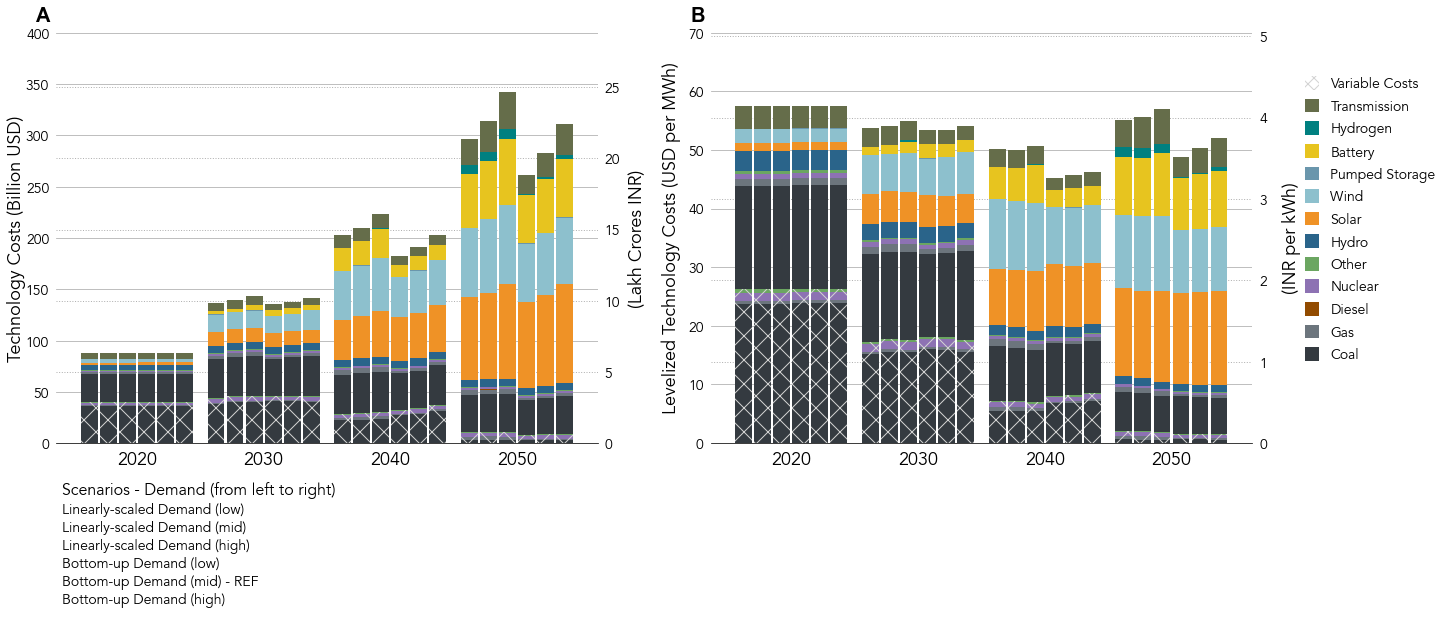

In [10]:
fig, _ax = plt.subplot_mosaic([['A', 'B']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.5), 
                              gridspec_kw = {'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 20, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

div_line_len = .64
y_period_loc = -.62

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['A'], costs_['tech_cost'], costs_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'(Lakh Crores INR)',
                                    y_lim_max    = 400,
                                    y_grid_inc   = 50,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['B'], costs_['tech_cost'], costs_['demand'], costs_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'(INR per kWh)',
                                        y_lim_max    = 70,
                                        y_grid_inc   = 10,
                                        legend       = True)

line1    = Line2D([], [], color = 'None', solid_capstyle ='round')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(costs_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, loc            = (0., -.4125),
                                         title          = 'Scenarios - Technology Cost (from left to right)',
                                         frameon        = False,
                                         labelspacing   = 0.175,
                                         title_fontsize = 16,
                                         ncol           = 1,
                                         handletextpad  = -1.,
                                         prop           = {'size': 14})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/cost-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + '/cost-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Supporting Figures

In [146]:
iced_                = {}
iced_['scen_labels'] = pd.read_csv(path_to_csvs + '/iced-scenario_labels.csv') 

cost_, demand_ = _load_cost(iced_['scen_labels'])
cost_ = _group_tech(cost_, tech_labels_)

iced_['tech_cost'], iced_['demand'] = _group_cost_by_tech(cost_, demand_, iced_['scen_labels'])

idx_ = iced_['tech_cost']['technology'] == 'Transmission Losses'
iced_['tech_cost'].loc[idx_, 'fixed_cost'] += 5.9e9

iced_p_ = iced_['tech_cost'].drop(columns = ['load_zone'])
iced_p_.to_csv(path_to_tables + '/iced-technology_costs.csv', index = False)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced


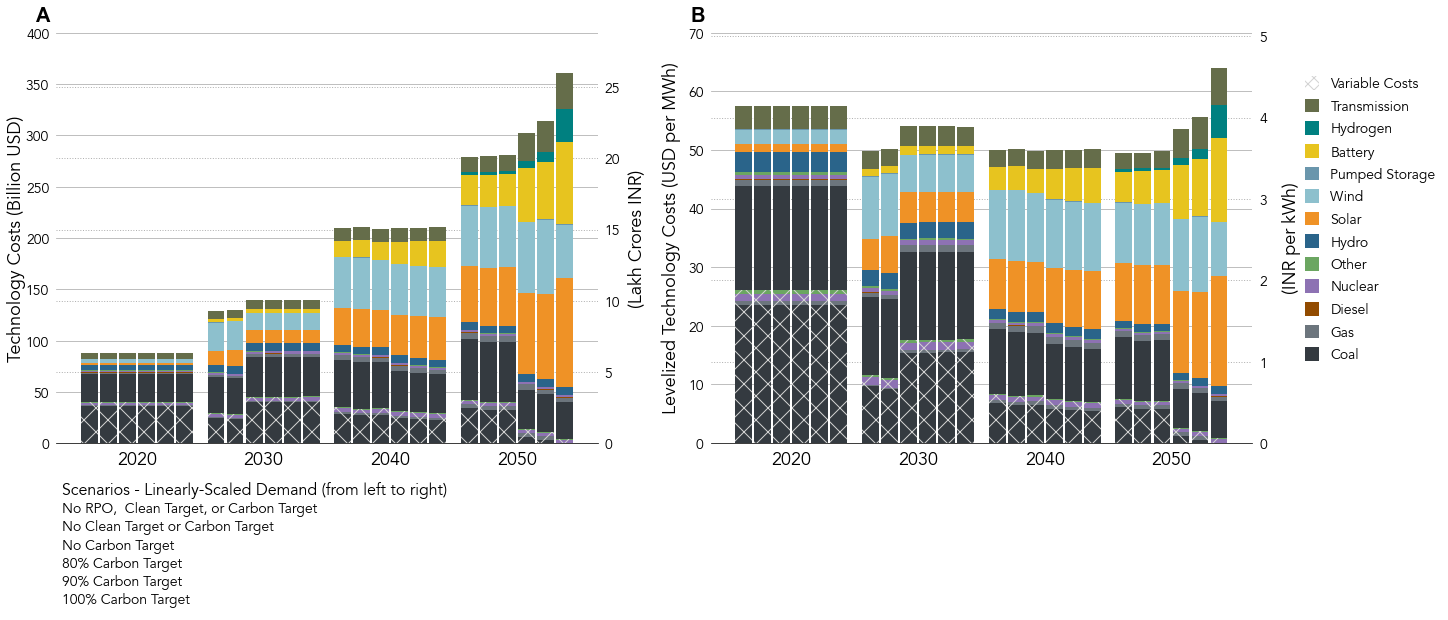

In [147]:
fig, _ax = plt.subplot_mosaic([['A', 'B']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.5), 
                              gridspec_kw = {'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 20, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

div_line_len = .64
y_period_loc = -.62

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['A'], iced_['tech_cost'], iced_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'(Lakh Crores INR)',
                                    y_lim_max    = 400,
                                    y_grid_inc   = 50,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['B'], iced_['tech_cost'], iced_['demand'], iced_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'(INR per kWh)',
                                        y_lim_max    = 70,
                                        y_grid_inc   = 10,
                                        legend       = True)

line1    = Line2D([], [], color = 'None', solid_capstyle ='round')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(iced_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, loc            = (0., -.4125),
                                         title          = 'Scenarios - Linearly-Scaled Demand (from left to right)',
                                         frameon        = False,
                                         labelspacing   = 0.175,
                                         title_fontsize = 16,
                                         ncol           = 1,
                                         handletextpad  = -1.,
                                         prop           = {'size': 14})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/iced-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/iced-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [148]:
pier_                = {}
pier_['scen_labels'] = pd.read_csv(path_to_csvs + '/pier-scenario_labels.csv')

cost_, demand_ = _load_cost(pier_['scen_labels'])
cost_ = _group_tech(cost_, tech_labels_)

pier_['tech_cost'], pier_['demand'] = _group_cost_by_tech(cost_, demand_, pier_['scen_labels'])

idx_ = pier_['tech_cost']['technology'] == 'Transmission Losses'
pier_['tech_cost'].loc[idx_, 'fixed_cost'] += 5.9e9

pier_p_ = pier_['tech_cost'].drop(columns = ['load_zone'])
pier_p_.to_csv(path_to_tables + '/pier-technology_costs.csv', index = False)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_80CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_100CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier


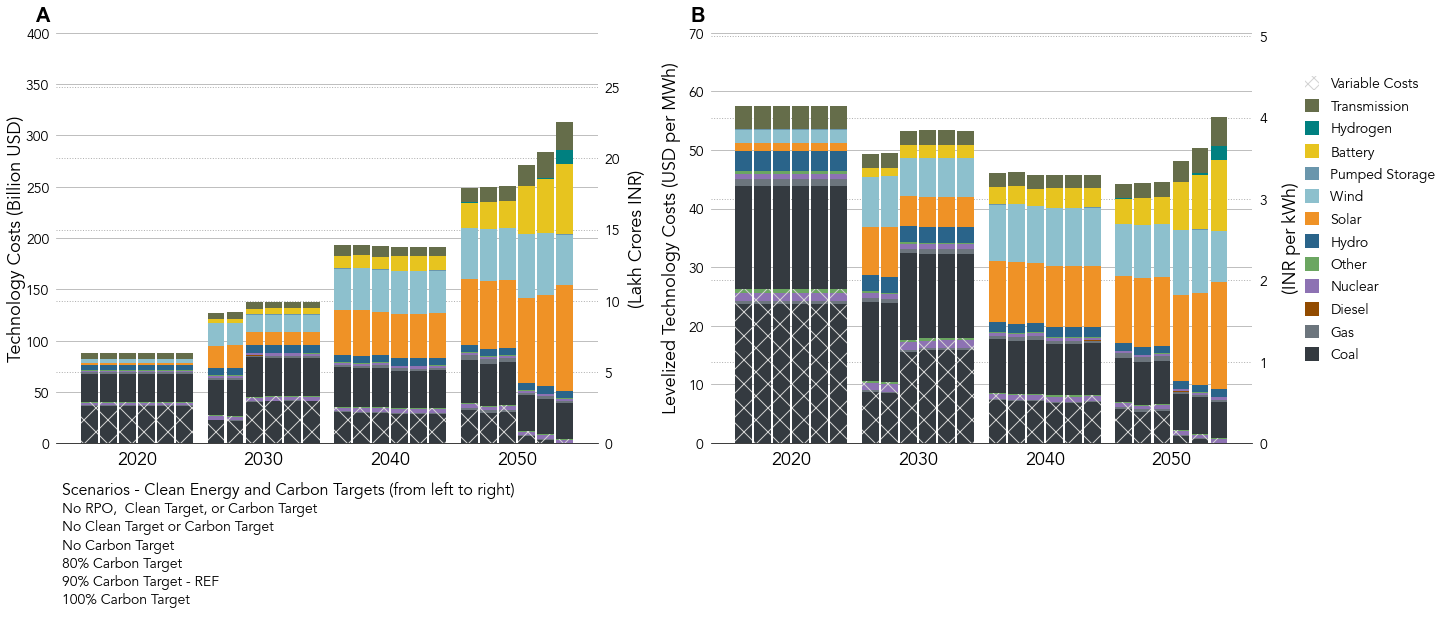

In [149]:
fig, _ax = plt.subplot_mosaic([['A', 'B']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.5), 
                              gridspec_kw = {'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 20, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['A'], pier_['tech_cost'], pier_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'(Lakh Crores INR)',
                                    y_lim_max    = 400,
                                    y_grid_inc   = 50,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['B'], pier_['tech_cost'], pier_['demand'], pier_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'(INR per kWh)',
                                        y_lim_max    = 70,
                                        y_grid_inc   = 10,
                                        legend       = True)

line1    = Line2D([], [], color = 'None', solid_capstyle ='round')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(pier_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, loc            = (0., -.4125),
                                         title          = 'Scenarios - Clean Energy and Carbon Targets (from left to right)',
                                         frameon        = False,
                                         labelspacing   = 0.175,
                                         title_fontsize = 16,
                                         ncol           = 1,
                                         handletextpad  = -1.,
                                         prop           = {'size': 14})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/pier-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/pier-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [6]:
demands_                = {}
demands_['scen_labels'] = pd.read_csv(path_to_csvs + '/demand-scenario_labels.csv') 

cost_, demand_ = _load_cost(demands_['scen_labels'])
cost_ = _group_tech(cost_, tech_labels_)

demands_['tech_cost'], demands_['demand'] = _group_cost_by_tech(cost_, demand_, demands_['scen_labels'])

idx_ = demands_['tech_cost']['technology'] == 'Transmission Losses'
demands_['tech_cost'].loc[idx_, 'fixed_cost'] += 5.9e9

demands_p_ = demands_['tech_cost'].drop(columns = ['load_zone'])
demands_p_.to_csv(path_to_tables + '/demand-technology_costs.csv', index = False)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERhigh /Users/Guille/Desktop/india_power/scenarios/demand


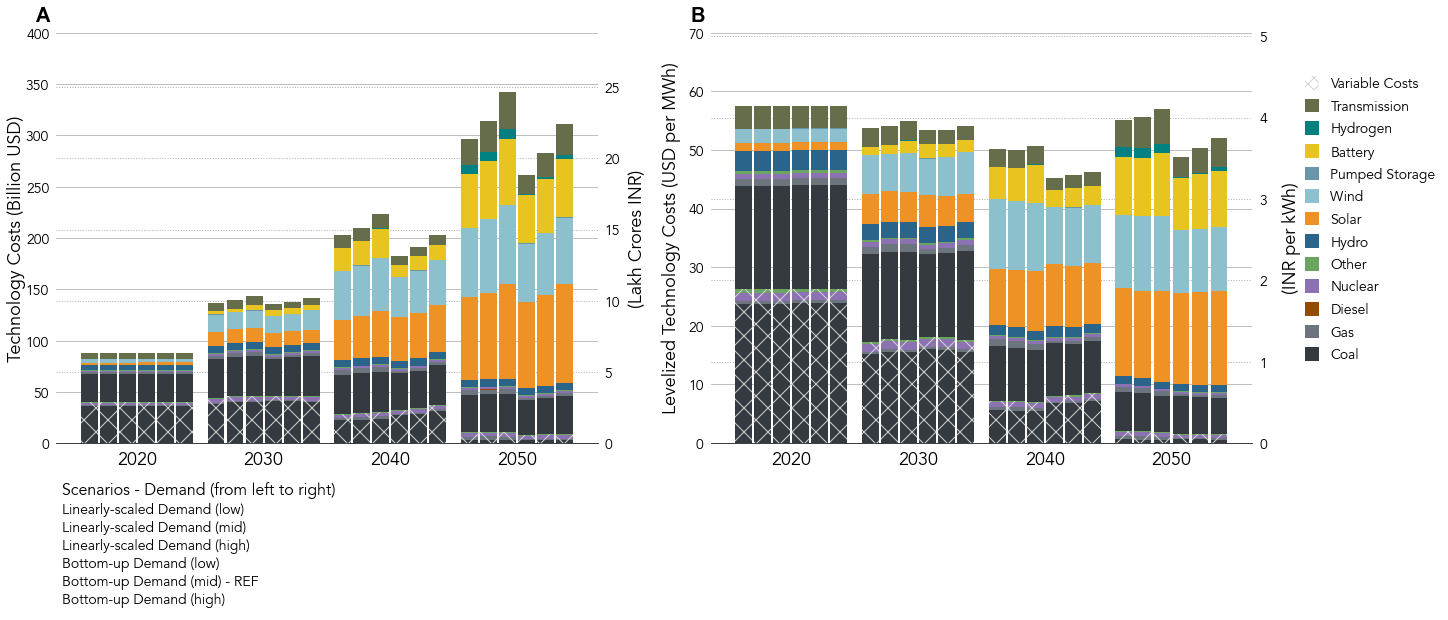

In [7]:
fig, _ax = plt.subplot_mosaic([['A', 'B']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.5), 
                              gridspec_kw = {'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 20, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['A'], demands_['tech_cost'], demands_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'(Lakh Crores INR)',
                                    y_lim_max    = 400,
                                    y_grid_inc   = 50,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['B'], demands_['tech_cost'], demands_['demand'], demands_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'(INR per kWh)',
                                        y_lim_max    = 70,
                                        y_grid_inc   = 10,
                                        legend       = True)

line1    = Line2D([], [], color = 'None', solid_capstyle ='round')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(demands_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, loc            = (0., -.4125),
                                         title          = 'Scenarios - Demand (from left to right)',
                                         frameon        = False,
                                         labelspacing   = 0.175,
                                         title_fontsize = 16,
                                         ncol           = 1,
                                         handletextpad  = -1.,
                                         prop           = {'size': 14})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/demand-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/demand-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [153]:
alternative_                 = {}
alternative_['scen_labels']  = pd.read_csv(path_to_csvs + '/alternative-scenario_labels.csv') 

cost_, demand_ = _load_cost(alternative_['scen_labels'])
cost_ = _group_tech(cost_, tech_labels_)

alternative_['tech_cost'], alternative_['demand'] = _group_cost_by_tech(cost_, demand_, alternative_['scen_labels'])

idx_ = alternative_['tech_cost']['technology'] == 'Transmission Losses'
alternative_['tech_cost'].loc[idx_, 'fixed_cost'] += 5.9e9

alternative_p_ = alternative_['tech_cost'].drop(columns = ['load_zone'])
alternative_p_.to_csv(path_to_tables + '/alternative-technology_costs.csv', index = False)

VREmid_STmid_CONVmid_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/alternative
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_PSH_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/alternative
VREmid_STmid_CONVmid_N_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/alternative
VREmid_STmid_CONVmid_H2PSH_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/alternative
VREmid_STmid_CONVmid_H2PSHN_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/alternative


In [ ]:
fig, _ax = plt.subplot_mosaic([['A', 'B']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'wspace': .1, 
                                             'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 20, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['A'], alternative_['tech_cost'], alternative_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'Technology Costs (Trillion INR)',
                                    y_lim_max    = 373.5,
                                    y_period_loc = -122,
                                    y_grid_inc   = 50,
                                    div_line_len = 0.335,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['B'], alternative_['tech_cost'], alternative_['demand'], alternative_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'Levelized Technology Costs (INR per MWh)',
                                        y_lim_max    = 64,
                                        y_period_loc = -21,
                                        y_grid_inc   = 10,
                                        div_line_len = 0.335,
                                        legend       = True)

plt.savefig(path_to_images + '/alternative-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/alternative-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Technology Costs

In [ ]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 
scen_labels_ = pd.read_csv(path_to_csvs + '/policy_iced-scenario_labels.csv') 

In [9]:
tech_cost_, demand_                       = _load_cost(scen_labels_)
grouped_tech_cost_                        = _group_cost_technologies(tech_cost_, tech_labels_)
grouped_tech_cost_by_tech_, total_demand_ = _group_tech_cost_by_tech(grouped_tech_cost_, demand_, scen_labels_)

grouped_tech_cost_by_tech_.loc[grouped_tech_cost_by_tech_['technology'] == 'Tx_Losses', 'fixed_cost'] += 5.9e9

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy


KeyboardInterrupt: 

### Levelized Technology Costs

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid


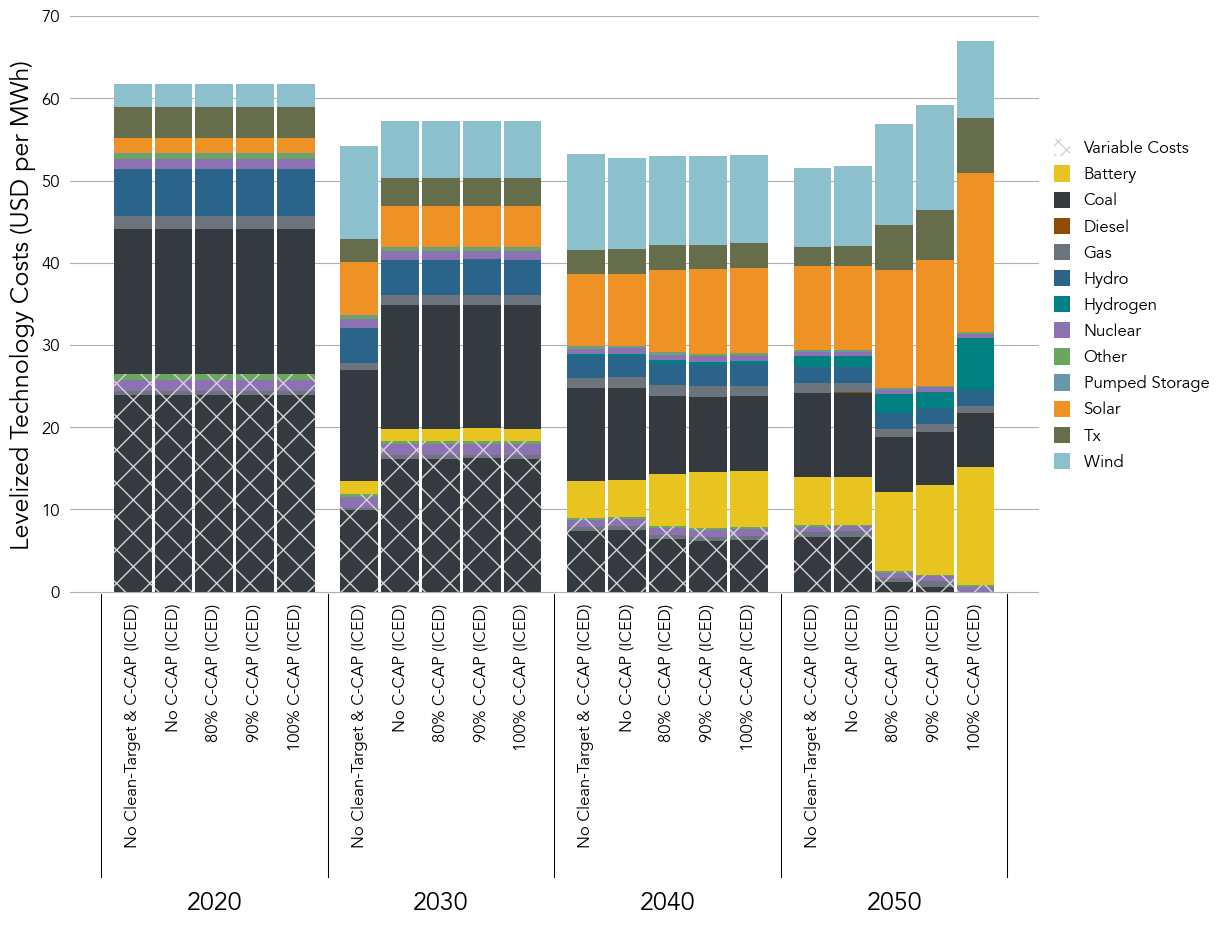

In [12]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax, grouped_tech_cost_by_tech_, total_demand_,
                                        scen_labels_, tech_labels_, 
                                        units_label = r'Levelized Technology Costs (USD per MWh)')

plt.savefig(path_to_images + r'/levelized_fixed_and_variable_costs.png', 
            bbox_inches = 'tight',
            dpi         = 600)

plt.show()

### Total Technology Costs

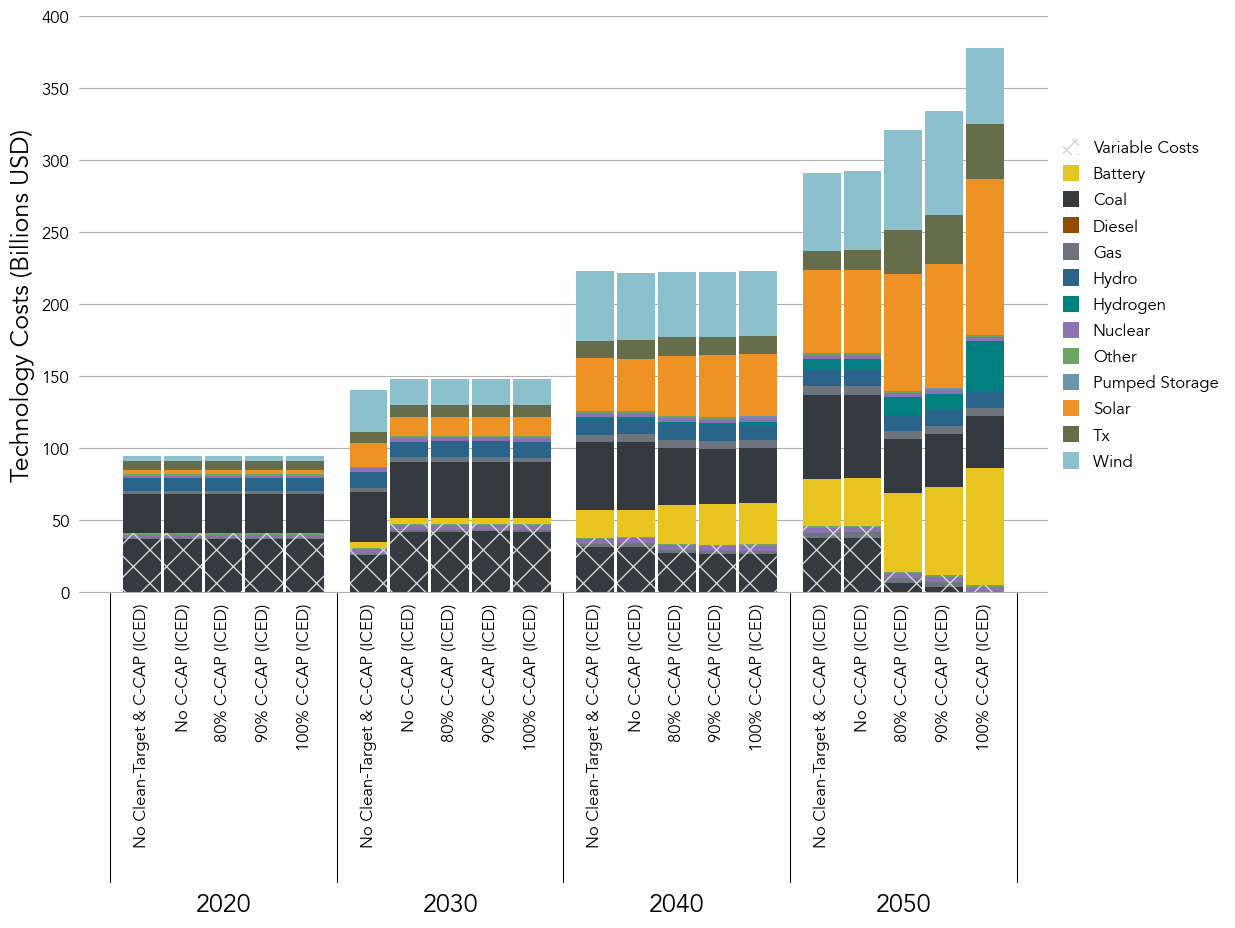

In [11]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax, grouped_tech_cost_by_tech_,
                                    scen_labels_, tech_labels_, 
                                    units_label  = r'Technology Costs (Billions USD)')

plt.savefig(path_to_images + r'/fixed_and_variable_costs.png', 
            bbox_inches = 'tight',
            dpi         = 600)

plt.show()